In [1]:

from gensim.models import KeyedVectors 
from gensim.test.utils import datapath 
import pprint
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [10, 5] 
# ----------------

In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/' from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD 
from sklearn.decomposition import PCA
START_TOKEN = '<START>' 
END_TOKEN = '<END>'
np.random.seed(0) 
random.seed(0)

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/dulajprabasha/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [3]:
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

unzip:  cannot find or open /root/nltk_data/corpora/reuters.zip, /root/nltk_data/corpora/reuters.zip.zip or /root/nltk_data/corpora/reuters.zip.ZIP.


In [4]:
from nltk.corpus import reuters

In [5]:
def read_corpus(category="grain"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
            """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [6]:
reuters_corpus = read_corpus() 
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'china', 'daily', 'says', 'vermin', 'eat', '7', '-', '12', 'pct', 'grain', 'stocks',
  'a', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume',
  'between', 'seven', 'and', '12', 'pct', 'of', 'china', "'", 's', 'grain', 'stocks', ',', 'the',
  'china', 'daily', 'said', '.', 'it', 'also', 'said', 'that', 'each', 'year', '1', '.', '575',
  'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'china', "'", 's', 'fruit', 'output', 'are',
  'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30',
  'pct', ',', 'of', 'its', 'vegetables', '.', 'the', 'paper', 'blamed', 'the', 'waste', 'on',
  'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', '.', 'it', 'said', 'the',
  'government', 'had', 'launched', 'a', 'national', 'programme', 'to', 'reduce', 'waste', ',',
  'calling', 'for', 'improved', 'technology', 'in', 'storage', 'and', 'preservation', ',', 'and',
  'greater', 'production', 'of', 

In [7]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = [] 
    n_corpus_words = -1
    # ------------------
    # Write your implementation here.
    # ------------------
    corpus_words = [y for x in corpus for y in x]
    corpus_words = list(set(corpus_words))
    corpus_words = sorted(corpus_words)
    n_corpus_words = len(corpus_words)

    return corpus_words, n_corpus_words

In [8]:

# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------
# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)
# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN]) 
ans_num_corpus_words = len(ans_test_corpus_words)
# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words) # Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:".format(str(ans_test_corpus_words), str(test_corpus_words))
# Print Success
print ("-" * 80) 
print("Passed All Tests!") 
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [9]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):

    Co-occurence matrix of word counts.
    The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus) 
    M = None
    word2ind = {}

    for i, word in enumerate(words):
        word2ind[word] = i

    M = np.zeros((n_words, n_words))

    for doc in corpus:
        for i, word in enumerate(doc):
            for j in range(max(0, i - window_size), min(len(doc), i + window_size + 1)):
                if i != j:
                    M[word2ind[word], word2ind[doc[j]]] += 1

# ------------------
# Write your implementation here.
# ------------------
    return M, word2ind

In [10]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------
# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
# Correct M and word2ind
M_test_ans = np.array(
[[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN]) 
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))
# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test) # Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)
# Test correct M values
for w1 in word2ind_ans.keys(): 
     idx1 = word2ind_ans[w1]
     for w2 in word2ind_ans.keys():
          idx2 = word2ind_ans[w2]
          student = M_test[idx1, idx2] 
          correct = M_test_ans[idx1, idx2] 
          if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))
# Print Success
print ("-" * 80) 
print("Passed All Tests!") 
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [11]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10 # Use this parameter in your call to `TruncatedSVD` M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    svd = TruncatedSVD(n_components=k, n_iter=n_iters)

    M_reduced = svd.fit_transform(M)

    # ------------------
    # Write your implementation here.
    # ------------------
    print("Done.") 
    return M_reduced

In [12]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------
# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)
# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10) 
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)
# Print Success
print ("-" * 80) 
print("Passed All Tests!") 
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [13]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    print(M_reduced)
    for i,word in enumerate(words):
        x,y = M_reduced[word2ind[word]]
        plt.scatter(x,y,marker='x',color='red')
        plt.text(x+0.005, y+0.005, word, fontsize=9)
        
    plt.show()
    
    # ------------------
    # Write your implementation here.
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:
[[ 1  1]
 [-1 -1]
 [ 1 -1]
 [-1  1]
 [ 0  0]]


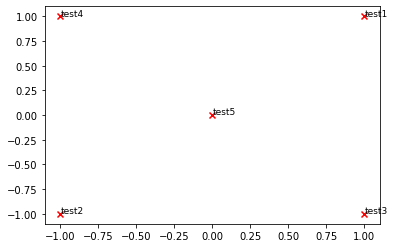

--------------------------------------------------------------------------------


In [14]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# ---------------------
print ("-" * 80)
print ("Outputted Plot:")
M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]]) 
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4} 
words = ['test1', 'test2', 'test3', 'test4', 'test5'] 
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)
print ("-" * 80)

Running Truncated SVD over 7146 words...
Done.
[[ 0.99917446  0.04062521]
 [ 0.62775762 -0.77840887]
 [ 0.9982698  -0.05879978]
 ...
 [ 0.8966093   0.4428225 ]
 [ 0.61609677 -0.78767047]
 [ 0.99987572 -0.01576542]]


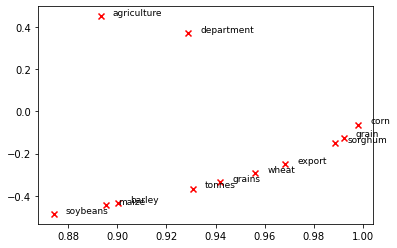

In [15]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus) 
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
words = ['tonnes', 'grain', 'wheat', 'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum'] 
plot_embeddings(M_normalized, word2ind_co_occurrence, words)

In [16]:
def load_embedding_model(): 
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key))) 
    return wv_from_bin

In [17]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes # ----------------------------------- 
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [18]:
def get_matrix_of_vectors(wv_from_bin, required_words=['tonnes', 'grain', 'wheat', 'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']):
    """ Get matrix of word vectors for the words in the list "required_words"
        Params:
            wv_from_bin: All 400000 embeddings, each lengh 200
            required_words (list of strings): words whose embeddings we want to visualize
        Return:
            M (numpy matrix of shape (number of words in required_words, 200)): matrix of 200-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
    """
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words)) 
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try: 
            M.append(wv_from_bin.get_vector(w)) 
            word2ind[w] = curInd
            curInd += 1
        except KeyError: 
            continue
    for w in required_words:
        if w in words: 
            continue
        try: 
            M.append(wv_from_bin.get_vector(w)) 
            word2ind[w] = curInd
            curInd += 1
        except KeyError: 
            continue
    M = np.stack(M) 
    print("Done.") 
    return M, word2ind

In [19]:
#----------------------------------------------------------------- # Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions # Note: This should be quick to run
# ----------------------------------------------------------------- 
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


[[-0.7890665  -0.6143078 ]
 [-0.95359886  0.30107996]
 [-0.8667829   0.49868575]
 ...
 [ 0.64708155 -0.7624207 ]
 [ 0.57155013 -0.8205672 ]
 [-0.25269789 -0.9675453 ]]


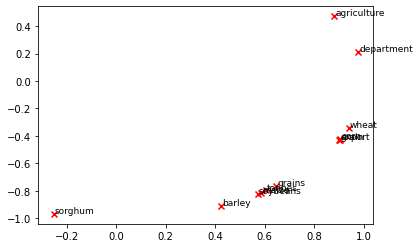

In [20]:
words = ['tonnes', 'grain', 'wheat', 'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum'] 
plot_embeddings(M_reduced_normalized, word2ind, words)

In [21]:
wv_from_bin.most_similar("free")

[('allowed', 0.6128848195075989),
 ('without', 0.6061280965805054),
 ('only', 0.6010986566543579),
 ('go', 0.5948979258537292),
 ('for', 0.5921095013618469),
 ('allowing', 0.5837085247039795),
 ('all', 0.5812143683433533),
 ('available', 0.5735388398170471),
 ('give', 0.5721980333328247),
 ('right', 0.5714613199234009)]

In [22]:
w1 = "warning"
w2 = "safety"
w3 = "danger"

print(wv_from_bin.distance(w1, w2))
print(wv_from_bin.distance(w1, w3))

0.530224084854126
0.42602527141571045


In [23]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.644661009311676),
 ('wife', 0.6445354223251343)]


g+w-m
man and woman would lie closer to grandfather amd grandmother

In [24]:
pprint.pprint(wv_from_bin.most_similar(positive=['king', 'woman'], negative=['man']))

[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


In [25]:
pprint.pprint(wv_from_bin.most_similar(positive=['alcohol', 'wine'], negative=['sugar']))

[('wines', 0.5810700058937073),
 ('drink', 0.5437963008880615),
 ('drinking', 0.5255488753318787),
 ('alcoholic', 0.5128150582313538),
 ('tasting', 0.5092472434043884),
 ('beer', 0.4995408058166504),
 ('champagne', 0.48376935720443726),
 ('drinkers', 0.4710392653942108),
 ('drunk', 0.46856796741485596),
 ('liquor', 0.4676039516925812)]


was expecting grape

In [26]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be # most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['girl', 'toy'], negative=['boy']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['boy', 'toy'], negative=['girl']))

[('toys', 0.7094953060150146),
 ('doll', 0.5932914614677429),
 ('dolls', 0.570662260055542),
 ('barbie', 0.5407706499099731),
 ('mattel', 0.5328551530838013),
 ('accessories', 0.5206909775733948),
 ('hasbro', 0.49227219820022583),
 ('jewelry', 0.47385692596435547),
 ('lego', 0.4690813422203064),
 ('apparel', 0.46136239171028137)]

[('toys', 0.71570885181427),
 ('hasbro', 0.5164632797241211),
 ('robot', 0.47317108511924744),
 ('pet', 0.4670490324497223),
 ('manufacturer', 0.4668163061141968),
 ('mattel', 0.4582391679286957),
 ('lego', 0.45811763405799866),
 ('miniature', 0.4441472291946411),
 ('makers', 0.44298243522644043),
 ('manufactured', 0.44275349378585815)]


girls play with dolls while boys play with branded toys

In [39]:
pprint.pprint(wv_from_bin.most_similar(positive=['math', 'american'], negative=['asian']))

[('teacher', 0.5040789246559143),
 ('mathematics', 0.4934282898902893),
 ('teach', 0.47560355067253113),
 ('teaches', 0.4585683047771454),
 ('teaching', 0.4550301730632782),
 ('science', 0.4543231129646301),
 ('taught', 0.45380035042762756),
 ('curriculum', 0.45312097668647766),
 ('elementary', 0.44580549001693726),
 ('writing', 0.44507816433906555)]


2.9 test cosine similarity for known common biases